In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


# Load the GearBox data

In [27]:
import load_data

pth1 = 'data/BrokenTooth'
pth2 = 'data/Healthy'

window_len = 300  # How many window_len as 1 feature point 
inference_data_point = 5 # This value should be considered the MCU rom size. 5*300*10*2 = 30000 float points

broken_df_train, broken_df_test  = load_data.create_test_train_df_fromRaw(pth1 , 1, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))        
healthy_df_train, healthy_df_test = load_data.create_test_train_df_fromRaw(pth2 , 0, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))

#broken_df  = load_data.create_df_fromRaw(pth1 , 1, (load_data.addCol_load, load_data.addCol_fault))        
#healthy_df = load_data.create_df_fromRaw(pth2 , 0, (load_data.addCol_load, load_data.addCol_fault))

In [28]:
broken_df_test
#broken_df_train

,a1,a2,a3,a4,load,fault
0,2.350390,1.454870,-1.667080,-2.055610,0.0,1.0
1,2.452970,1.400100,-2.825100,0.984487,0.0,1.0
2,-0.241284,-0.267390,0.793540,0.605862,0.0,1.0
3,1.130270,-0.890918,0.696969,0.613068,0.0,1.0
4,-1.296140,0.980479,-1.130560,-0.346971,0.0,1.0
...,...,...,...,...,...,...
14995,-3.443520,-0.361539,-0.376093,-2.447550,90.0,1.0
14996,2.458310,-2.838840,0.191190,-0.201169,90.0,1.0
14997,-0.755909,3.982960,-2.321580,0.749357,90.0,1.0
14998,1.299520,4.402300,-2.232460,0.535038,90.0,1.0


# Feature Process

In [29]:
import feature_process

# Calculate the windows size features, combine 300 data as 1 points. 
Data_healthy, Lable_healthy = feature_process.window_feature_autoencoder(healthy_df_train, 0, window_len, 4, 16)#200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken, Lable_broken = feature_process.window_feature_autoencoder(broken_df_train, 1, window_len, 4, 16)
print(type(Data_healthy), type(Lable_healthy))
print("feature array shape of healthy point: {}, {}".format(Data_healthy.shape, Lable_healthy.shape))
print("feature array shape of broken point: {}, {}".format(Data_broken.shape, Lable_broken.shape))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
feature array shape of healthy point: (3336, 16), (3336,)
feature array shape of broken point: (3301, 16), (3301,)


In [30]:
# Create the random 80% train and 20% test
train_data, test_data, train_labels, test_labels = feature_process.concatenate_data(Data_healthy,Data_broken,Lable_healthy,Lable_broken, 0.1, 21)
print("train data shape: {}, {}".format(train_data.shape, train_labels.shape))
print("test data shape: {}, {}".format(test_data.shape, test_labels.shape))
# save the max&min val
max_val = tf.reduce_max(train_data)
min_val = tf.reduce_min(train_data)


train data shape: (5973, 16), (5973,)
test data shape: (664, 16), (664,)


# DNN

## DNN training

In [31]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential

early_stop = EarlyStopping(monitor='loss', patience=2)
model = Sequential()

model.add(Dense(4, activation='relu', input_shape=(16,),kernel_initializer='random_uniform'))
model.add(Dense(8, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(16, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(8, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(2, activation='softmax',kernel_initializer='random_uniform'))
model_settings = {}

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_17 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 18        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


In [32]:
hist = model.fit(train_data , train_labels , epochs=100, batch_size=32, validation_split=0.2)
#, batch_size=1024

Epoch 1/100
150/150 [==============================] - 1s 2ms/step - loss: 0.5257 - accuracy: 0.7306 - val_loss: 0.2811 - val_accuracy: 0.9699
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.1213 - accuracy: 0.9607 - val_loss: 0.0997 - val_accuracy: 0.9573
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0910 - accuracy: 0.9648 - val_loss: 0.1076 - val_accuracy: 0.9548
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0846 - accuracy: 0.9682 - val_loss: 0.0556 - val_accuracy: 0.9808
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0795 - accuracy: 0.9711 - val_loss: 0.0536 - val_accuracy: 0.9824
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0830 - accuracy: 0.9676 - val_loss: 0.0579 - val_accuracy: 0.9799
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.9682 - val_loss: 0.0557 - val_accuracy: 0.9808

## Test Result

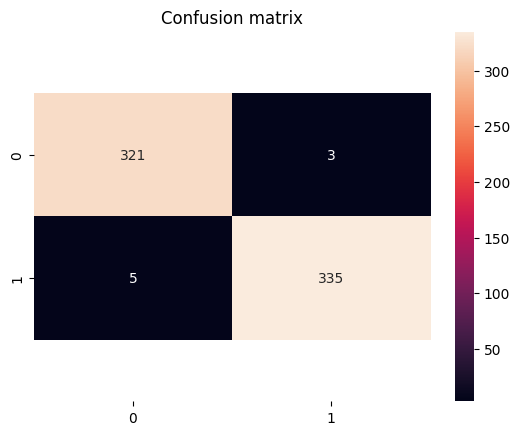

ROOT MEAN SQUARE ERROR = 0.10976425998969035
Accuracy = 0.9879518072289156
Precision = 0.9911242603550295
Recall = 0.9852941176470589


In [33]:
Dnn_model = model  # pass the model in order to be used latter
from sklearn.metrics import confusion_matrix, classification_report

prediction = Dnn_model.predict(test_data,verbose = 0)
#print(test_data[0:2])
#print(prediction)
y_pred = np.argmax(prediction,axis = -1)

# Confusion matrix heatmap
conf_matrix = confusion_matrix(test_labels, y_pred)
ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
# The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion matrix")
plt.show()
pred = y_pred.astype(int)

# Calculating root mean square error
rmse = np.sqrt(np.mean(((pred - test_labels) ** 2)))
print("ROOT MEAN SQUARE ERROR = {}".format(rmse))
print("Accuracy = {}".format(accuracy_score(test_labels,pred)))
print("Precision = {}".format(precision_score(test_labels,pred)))
print("Recall = {}".format(recall_score(test_labels,pred)))

## Show MCU Inference Result first
- This dataset is for MCU inference latter, and we use PC python to inference first.
- The Accuracy value should be almost same as MCU result latter.

feature array shape of test healthy point: (50, 16), (50,)
feature array shape of test broken point: (50, 16), (50,)


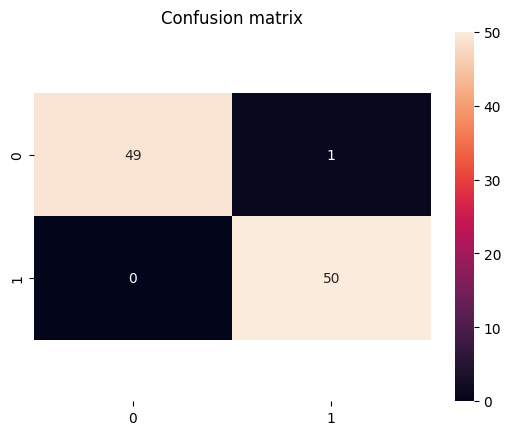

ROOT MEAN SQUARE ERROR = 0.1
Accuracy = 0.99
Precision = 0.9803921568627451
Recall = 1.0


In [34]:
# accuracy for MCU inference data

# calculate feature
Data_healthy_test, Lable_healthy_test = feature_process.window_feature_autoencoder(healthy_df_test, 0, window_len, 4, 16)#200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken_test, Lable_broken_test = feature_process.window_feature_autoencoder(broken_df_test, 1, window_len, 4, 16)
print("feature array shape of test healthy point: {}, {}".format(Data_healthy_test.shape, Lable_healthy_test.shape))
print("feature array shape of test broken point: {}, {}".format(Data_broken_test.shape, Lable_broken_test.shape))
inference_data = np.concatenate([Data_healthy_test, Data_broken_test], axis =0)
inference_label = np.concatenate([Lable_healthy_test, Lable_broken_test], axis =0)

# Predict
prediction = Dnn_model.predict(inference_data, verbose = 0)
y_pred = np.argmax(prediction,axis = -1)

# Confusion matrix heatmap
conf_matrix = confusion_matrix(inference_label, y_pred)
ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
# The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion matrix")
plt.show()
pred = y_pred.astype(int)

# Calculating root mean square error
rmse = np.sqrt(np.mean(((pred - inference_label) ** 2)))
print("ROOT MEAN SQUARE ERROR = {}".format(rmse))
print("Accuracy = {}".format(accuracy_score(inference_label,pred)))
print("Precision = {}".format(precision_score(inference_label,pred)))
print("Recall = {}".format(recall_score(inference_label,pred)))

# TensorFlow Lite Conversion

In [17]:
# If we're happy with the performance, save the model
ori_model = Dnn_model
keras_model_name = 'dnn'

tf.saved_model.save(ori_model, keras_model_name)

INFO:tensorflow:Assets written to: dnn\assets


In [18]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
tflite_model = converter.convert()
open(keras_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\CYCHEN38\AppData\Local\Temp\tmpqp2mdulg\assets


4484

In [19]:
def tflite_to_tflu(models_path, c_model_name, keras_model_name, threshold, maxV, minV):
    
    tflite_name = (keras_model_name + '.tflite')
    my_f_name = (os.path.join(models_path, c_model_name) + '.cc')
    ! python tflite_to_tflu_para.py --tflite_path $tflite_name --output_path $my_f_name --window_size_sample $window_len --max_val_train $maxV --min_val_train $minV --threshold_val $threshold

models_path = 'model'
c_model_name = r'Gearbox_fault_' + keras_model_name    
tflite_to_tflu(models_path, c_model_name, keras_model_name, 0, max_val.numpy(), min_val.numpy())    